# Metric Learning

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from omegaconf import OmegaConf
from model.model import KLLossMetricLearning, loss_different_class, loss_same_class, KL_d, KL_dreg
from data_utils import cub2011
from data_utils import stanford_cars
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
IMAGE_SIZE = 16

## Download data

### Download model
We are basing our experiments on pre-trained resnet50

In [3]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
preprocess_transforms = weights.transforms()

In [4]:
net = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

### Download datasets
We are downloading two benchmark datasets:
* Stanford-Cars (CARS 196) - https://www.kaggle.com/datasets/ryanholbrook/cars196
* CUB 200 2011 - https://www.kaggle.com/datasets/xiaojiu1414/cub-200-2011

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

batch_size = 32

In [6]:
cars_trainset = stanford_cars.download_cars('./data', train=True, download=True, transforms=train_transform)
cars_testset = stanford_cars.download_cars('./data', train=True, download=False, transforms=transform)

cub_trainset = cub2011.download_cub('./data', train=True, download=True, transforms=train_transform)
cub_testset = cub2011.download_cub('./data', train=False, download=False, transforms=transform)

Skipping, found downloaded files in "./data/stanford-car-dataset-by-classes-folder" (use force=True to force download)
folder already exits in given location: ./data/stanford-car-dataset-by-classes-folder
Skipping, found downloaded files in "./data/cub2002011" (use force=True to force download)
folder already exits in given location: ./data/cub2002011


In [7]:
cars_trainloader = torch.utils.data.DataLoader(cars_trainset, batch_size=batch_size,
                                          shuffle=True, drop_last=True)
cars_testloader = torch.utils.data.DataLoader(cars_testset, batch_size=batch_size,
                                          shuffle=False, drop_last=True)
cub_trainloader = torch.utils.data.DataLoader(cub_trainset, batch_size=batch_size,
                                          shuffle=True, drop_last=True)
cub_testloader = torch.utils.data.DataLoader(cub_testset, batch_size=batch_size,
                                          shuffle=False, drop_last=True)

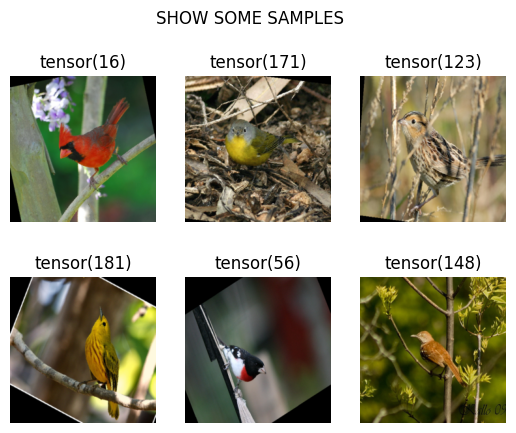

In [8]:
images, labels = next(iter(cub_trainloader))
cub2011.show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME BIRD SAMPLES')

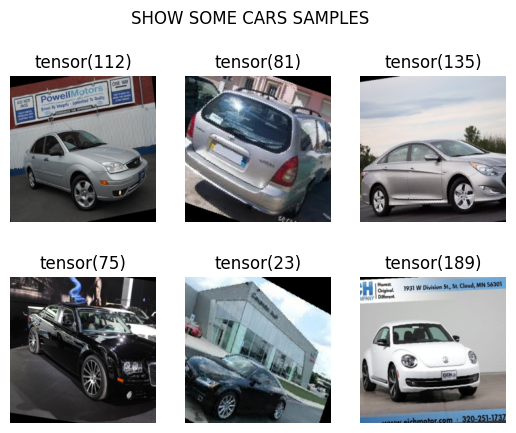

In [10]:
images, labels = next(iter(cars_trainloader))
cub2011.show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME CARS SAMPLES')

In [5]:
conf_path = os.path.join("configs", "model.yaml")
conf = OmegaConf.load(conf_path)
model = KLLossMetricLearning(**conf.get("model"))

In [25]:
images = torch.ones(64, 3, 32, 32)
model(images)
m1 = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0, 0.5]])
m2 = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0, 0.5]])
s1 = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0, 0.5]])
s2 = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0, 0.5]])
print(loss_same_class((m1, s1), (m2, s2), 0.5, 1))
print(loss_different_class((m1, s1), (m2, s2), 0.5, 1))

tensor(-3.2365)
tensor(6.1427)


In [24]:
0.5 * KL_dreg((m1.log(), s1), (m2.log(), s2))

tensor([6.7127,    inf])

In [12]:
torch.nn.KLDivLoss(size_average=False)(m1.log(), s1)

/home/richard/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(0.)